In [31]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from scipy.interpolate import interp1d,interp2d
from scipy import stats
from scipy import integrate
from bayes_opt import BayesianOptimization
import json
# import seaborn as sns
from scipy import special
from scipy import integrate

In [5]:
#Define the constants
main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 8.
z_max = 0.012/x0
z_start = 0.012/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

# Finding current

In [6]:
def Coil_field(I,R:np.array):
    n = 100
    s = 0.14 # in meter
    rad = 0.14 # in meter
    def dBx(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        # print(dl,rprime,dB)
        return dB[0]
    def dBy(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[1]
    
    def dBz(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[2]
    
    
    Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
    By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
    Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]
    
    return np.array([Bx,By,Bz])*n*10000 # Return in Gauss

In [17]:
def Error_function(I):
    zz = np.linspace(-0.012,0.012,101)/x0
    
    error = 0
    
    for z in zz:
        B_true = 1.308*1000*z*x0
        B_coil = Coil_field(I,np.array([0,0,z]))[2]
        
        error += (B_true - B_coil)**2
    return np.sqrt(error)*-1

In [21]:
pbounds ={'I' : (0.5,50)}

In [22]:
optimizer = BayesianOptimization(f=Error_function,pbounds=pbounds,verbose=13,random_state=1)

In [26]:
optimizer.maximize(init_points=0, n_iter=100)

|   iter    |  target   |     I     |
-------------------------------------
|  91       | -0.04036  |  38.43    |
|  92       | -0.04011  |  38.43    |
|  93       | -0.03998  |  38.43    |
|  94       | -0.03985  |  38.43    |
|  95       | -0.03969  |  38.43    |
|  96       | -0.03926  |  38.43    |
|  97       | -0.03968  |  38.43    |
|  98       | -0.03934  |  38.43    |
|  99       | -0.03922  |  38.43    |
|  100      | -0.0391   |  38.43    |
|  101      | -0.039    |  38.43    |
|  102      | -0.0388   |  38.43    |
|  103      | -0.03873  |  38.43    |
|  104      | -0.03841  |  38.43    |
|  105      | -0.03857  |  38.43    |
|  106      | -0.03833  |  38.43    |
|  107      | -0.03858  |  38.43    |
|  108      | -0.03817  |  38.43    |
|  109      | -0.03798  |  38.43    |
|  110      | -0.03782  |  38.43    |
|  111      | -0.03775  |  38.43    |
|  112      | -0.03762  |  38.43    |
|  113      | -0.03743  |  38.43    |
|  114      | -0.03735  |  38.43    |
|  115      

In [27]:
optimizer.max

{'target': -0.03698169664950378, 'params': {'I': 38.432740550936245}}

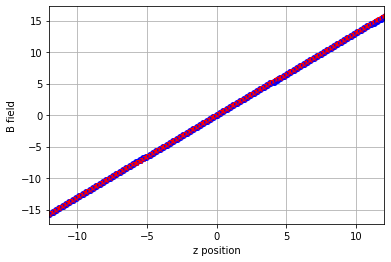

In [30]:
fig,ax = plt.subplots(1,1)
zz = np.linspace(-0.012,0.012,101)/x0
# for xx in xs:
#     ax.plot(xx*x0*1000,B_func(np.array([xx,0,0]))[0],'bo')
#     ax.plot(xx*x0*1000,-1/2*1.2528*xx*x0*1000,'r*')

for zs in zz:
    ax.plot(zs*x0*1000,Coil_field(38.43,zs)[2],'bo')
    ax.plot(zs*x0*1000,1.308*1000*x0*zs,'r*')
    
ax.set_xlim(-12,12)
ax.set_xlabel("z position")
ax.set_ylabel("B field")
ax.grid()

# Save the interpolation multi array

In [32]:
xs = np.linspace(-0.4,0.4,101)/x0
ys = np.linspace(-0.4,0.4,101)/x0

X,Y = np.meshgrid(xs,ys,sparse=1,indexing="xy")

it = np.nditer([X,Y],flags = ["refs_ok","multi_index"],op_flags = ["readonly","readonly"])

B = np.zeros((3,101,101))

for xx,yy in tqdm(it):
    temp = Coil_field(38.432740550936245,np.array([xx,yy,0.]))
    xind,yind = it.multi_index
    B[0][xind,yind] = temp[0]
    B[1][xind,yind] = temp[1]
    
Bx = interp2d(xs,ys,B[0])
By = interp2d(xs,ys,B[1])

10201it [02:07, 80.16it/s]                                                                                             


In [33]:
def B_func(R:np.array):
    return np.concatenate((Bx(R[0],R[1]),By(R[0],R[1]),np.zeros(1,)),axis=0)

In [34]:
B_func(np.array([123456,0.,0]))

array([-4.61039594e+00, -2.01706807e-15,  0.00000000e+00])

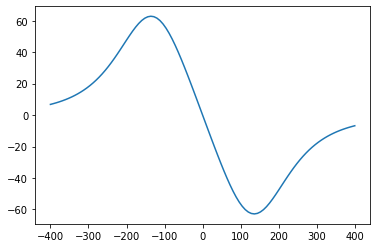

In [35]:
def Bx_approx(x):
    return B_func(np.array([x,0.,0.]))[0]

Bx_approx_v = np.vectorize(Bx_approx)

fig, ax = plt.subplots(1,1)

ax.plot(xs*x0*1000,Bx_approx_v(xs))

In [36]:
np.save("B_38_interpolate",B)